# PHP 2530: Bayesian Statistical Methods Homework I

In [2]:
#literally everything
import numpy as np
#for plotting our histograms, contours and lines
import matplotlib.pyplot as plt
#for making dataframes
import pandas as pd
#lets us use probability distributions like t, beta, gamma,etc.
from scipy.stats import norm, expon, poisson, uniform, nbinom, gamma
from scipy.special import gammaln #for computing the factorial
from IPython.display import display, Math, Latex

# Problem 3 (BDA 3rd Ed. Exercise 1.9)

Simulation of a queuing problem: a clinic has three doctors. Patients come into the clinic at
random, starting at 9 a.m., according to a Poisson process with time parameter 10 minutes: that
is, the time after opening at which the first patient appears follows an exponential distribution
with expectation 10 minutes and then, after each patient arrives, the waiting time until the next
patient is independently exponentially distributed, also with expectation 10 minutes. When a
patient arrives, he or she waits until a doctor is available. The amount of time spent by each
doctor with each patient is a random variable, uniformly distributed between 15 and 20 minutes.
The office stops admitting new patients at 4 p.m. and closes when the last patient is through
with the doctor.

>**(a) Simulate this process once. How many patients came to the office? How many had to
wait for a doctor? What was their average wait? When did the office close?**

In [4]:
def poisson_process(l,time,a,b,num): 
  '''
  ### MODEL PARAMETERS
  # l - rate parameter
  # time - time period we're interested in (lambda and time must be same scale)
  # a, b - time interval of time spent with patient. i.e. U ~ uniform(a,b)
  # num - number of doctors in the clinic
  '''
  #samples 10*mean(Poisson(lambda*t)) from T ~ Exp(lambda) and sums them. 
  arr_T = np.cumsum(expon.rvs(size=int(10*time/l),scale=l))
  #remove anything exceeding time. we don't take patients after that
  arr_T = np.array([x for x in arr_T if x <= time])
  # records appointment duration wrt opening time
  doc = np.repeat(0.0,num) #must be 0.0 to allow for floats.
  wait = np.zeros(len(arr_T))
  for j in range(len(arr_T)): 
      # waiting time of patient j
      wait[j] = doc.min() - arr_T[j]
      #appointment duration
      u = uniform.rvs(size=1, loc=a, scale=b-a)
      doc[doc.argmin()] = np.array([doc.min() if wait[j]>0 else arr_T[j]]) + u
  #if wait <= 0, they didn't wait. If wait > 0, they did
  #waiting time is simply sum of positive waiting times
  number_waited, time_waiting = len(wait[wait > 0]), sum(wait[wait > 0])
  #clinic closes either at 4:00pm, or when they finish
  closing_time = np.max([doc.max(),time])
  #in the case that no one waits on a doctor
  avg_wait_time = [ 0 if number_waited==0 else time_waiting / number_waited]
  ### STORES OUR INFORMATION
  df  = {
        'Number of Arrivals': [len(arr_T)],
        'Number of Patients': number_waited,
        'Average Waiting Time': avg_wait_time,
        'Closing Time': closing_time
                   } 
  df = pd.DataFrame(df)
  return(df)

In [5]:
# PART A
print(poisson_process(l=10,time=420,a=15,b=20,num=3))

   Number of Arrivals  Number of Patients  Average Waiting Time  Closing Time
0                  47                  14              6.866326    439.467246


>**(b) Simulate the process 100 times and estimate the median and 50\% interval for each of
the summaries in (a).**
 

In [8]:
#PART B 
#gets samples (note:_ convention for a variable whose value you don't care for)
w = [poisson_process(l=10,time=420,a=15,b=20,num=3) for _ in range(101)]
w = pd.concat(w)
#so we can see all the data
np.round(w.quantile([0.25,0.50,0.75], axis = 0),2)

,Number of Arrivals,Number of Patients,Average Waiting Time,Closing Time
0.25,37.0,6.0,4.92,425.38
0.50,41.0,12.0,6.24,431.97
0.75,47.0,18.0,8.04,435.75


# Problem 4 (BDA 3rd Ed., Exercise 2.4)

Predictive distributions: let y be the number of 6’s in 1000 independent rolls of a particular real die, which may be unfair. Let $\theta$ be the probability that the die lands on ‘6.’
Suppose your prior distribution for $\theta$ is as follows:

\begin{alignat*}{1}
Pr(\theta = 1/12) &= 0.25\\
Pr(\theta = 1/6) &= 0.50\\
Pr(\theta = 1/4) &= 0.25\\
\end{alignat*}


>**(a) Using the normal approximation for the conditional distributions, $p(y|\theta)$, sketch your
approximate prior predictive distribution for y.**

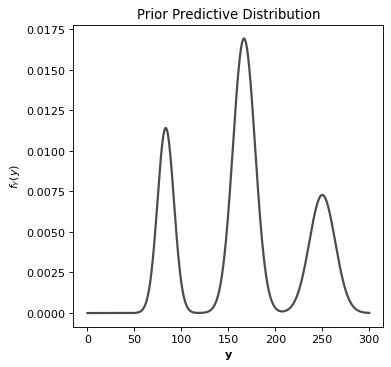

In [9]:
### PROBLEM 4 (BDA 3rd. Ed. 2.4)

#values that we want to plug in for our pdf
y = np.linspace(start=0, stop=300, num=1000)
#normal approx. to binomial
def fy(x,theta) : 
    mu = 1000*theta; sd = np.sqrt(1000*theta*(1-theta))
    return norm.pdf(x, loc = mu, scale = sd)

#sample space of parameter theta
theta_values = np.array([1/12,1/6,1/4])
#probability associated with each value of theta
theta_probs = np.array([0.25,0.5,0.25])

#does matrix multiplication. (1000x3)(2x1) -> 1000x1 vector
p = fy(y[:,None], theta_values).dot(theta_probs)

# Draw Plot
plt.figure(figsize=(5,5), dpi= 80) #dimensions of figure

ax = plt.axes() # Setting the background color of the plot 
ax.set_facecolor("white") # using set_facecolor() method

plt.plot(y,p,color="black",alpha=0.7,linewidth=2)
plt.xlabel('y',fontweight='bold')
plt.ylabel("$f_{Y}(y)$",fontweight='bold')
plt.title('Prior Predictive Distribution')
plt.show()

>**(b) Give approximate 5\%, 25\%, 50\%, 75\%, and 95\% points for the distribution of y. (Be
careful here: y does not have a normal distribution, but you can still use the normal
distribution as part of your analysis.)**

## METHOD 1: Quantile Approximation

One strategy to find the quantiles is to recognize that the weights (i.e. the prior probability values) reveal how much each individual gaussian contributes to the pdf.

The leftmost Gaussian contributes 25\% of the mass, so the 5\% quantile is simply the 20\% quantile of this Gaussian (i.e. 20\% of 25 is 5). 

Following similar logic the 25\% quantile is directly between the first spike and the second spike (through trial and error I have found that taking the 99.997\% of the first Gaussian gives extremely close results). 

By symmetry, the 50\% quantile is directly in the middle of the second spike.

The 75\% quantile is directly between the second and third spikes (taking the 99.96\% quantile of the second provides accurate results),

The 95\% quantile is given by the 80\% quantile of the third spike since the previous two gaussians contribute 75\% of the mass, we look for where the third gaussian contributes 20\% (i.e. 80\% of 25 is 20).


In [11]:
#Note, use 0.9999 for the quantiles in between. 1 gives you Infinity
q = [0.20,0.99997,0.50,0.9996,0.80]
mu_theta = np.array([1/12,1/12,1/6,1/6,1/4])
sd_theta = np.sqrt(1000*mu_theta*(1-mu_theta))

Q = norm.ppf(q,loc = 1000*mu_theta,scale = sd_theta)

#put into dataframe so it looks nice
Q = pd.DataFrame(np.round(Q,3).reshape(1,5),
                 columns= ["5%","25%","50%","75%","95%"])
print(Q)


,5.0%,25.0%,50.0%,75.0%,95.0%
0,75.98,118.0,166.67,206.45,261.52


## METHOD 2: 
Another equally valid method is to recognize that

\begin{alignat*}{1}
\int^{y}_{-\infty} p(y') dy' &=  \int^{y}_{-\infty} \sum_{\theta} p(y'|\theta)p(\theta) dy' &= \sum_{\theta} \int^{y}_{-\infty} p(y'|\theta)p(\theta) dy'\\
F(y) &= \sum_{\theta} F(y|\theta)p(\theta)\\
\end{alignat*}

This gives us a form for the cdf of a mixture model. From here we can use a line-search method to find the values y such that $F(y) - q = 0$, where q is our quantile value.


In [12]:
#METHOD 2: Root Finder

# GMQ- Gaussian Mixture Quantiles. Uses line search to find roots
def GMQ(p,theta,w,y,tol):
    '''
    Parameters
    ----------
    p : quantiles we wish to obtian values for
    theta : finite parameter space for theta
    w : weights attached to each theta
    y : Tupper bound of range to search over (i.e. we look from [0,y])
    tol : control parameter. smaller tol means more exact answer

    Returns
    -------
    Quantiles of the gaussian mixture model

    '''

    #cdf function
    def gmm(x,theta):
        mu = 1000*theta; sd = np.sqrt(1000*theta*(1-theta))
        return norm.cdf(x,loc=mu, scale = sd)
    #y values to plug into cdf; 
    x = np.arange(0,y+tol,tol)
    #values of function cdf(y)- q; length of quantile
    mass = gmm(x[:,None], theta).dot(w); n = len(p)
    ww = abs(mass[:,None]-p[None,:])
    quantile = x[ww.argmin(axis=0)]
    #names the quantiles we're looking for
    quantile_names = [str(100*p[j])+'%' for j in range(n)]
    #Nice, readable form
    quantiles = pd.DataFrame(quantile.reshape(1,n),
                            columns = quantile_names)
    return quantiles 

#quantile values
GMQ(p=np.array([0.05,0.25,0.50,0.75,0.95]),
    theta=theta_values,
    w=theta_probs,
    y=500,
    tol = 0.01)

,5%,25%,50%,75%,95%
0,75.978,118.406,166.667,206.18,261.524


# Problem 6: (BDA 3rd Ed., Exercise 2.8)

Normal distribution with unknown mean: a random sample of n students is drawn
from a large population, and their weights are measured. The average weight of the n
sampled students is $\bar{y} = 150$ pounds. Assume the weights in the population are normally
distributed with unknown mean $\theta$ and known standard deviation 20 pounds. Suppose
your prior distribution for $\theta$ is normal with mean 180 and standard deviation 40.

In [3]:
#functions for mean and variance of posterior
def var_n(n,a,b): return 1/(1/(a)**2 + n/(b)**2)
def mu_n(n,a,b,m,y): return var_n(n,a,b)*(m/(a)**2 + (n*y)/(b)**2)

mu = mu_n(n=np.array([10,10,100,100]),a=40,b=20,m=180,y=150)
var = var_n(n=np.array([10,10,100,100]),a=40,b=20)+np.array([0,20**2,0,20**2])

norm_ci = norm.ppf([0.025,0.975],loc = mu[:,None],scale = np.sqrt(var[:,None]))
norm_ci = np.round(norm_ci, 2) 

>**(c) For $n = 10$, give a 95\% posterior interval for $\theta$ and a 95\% posterior predictive interval
for $\tilde{y}$.**

In [4]:
# PART C
print(f"The 95% posterior interval for part c is {norm_ci[0,:]}, "
      f"the 95% predictive interval for part c is {norm_ci[1,:]} ")

The 95% posterior interval for part c is [138.49 162.98], the 95% predictive interval for part c is [109.66 191.8 ] 


>**(d) Do the same for n = 100.**

In [6]:
#PART D
print(f"the 95% posterior interval for part d is {norm_ci[2,:]}, and "
      f"the 95% predictive interval for part d is {norm_ci[3,:]}.")

the 95% posterior interval for part d is [146.16 153.99], and the 95% predictive interval for part d is [110.68 189.47].


# Problem 7 (BDA 3rd Ed., Exercise 2.10)

Discrete sample spaces: suppose there are N cable cars in San Francisco, numbered
sequentially from 1 to N. You see a cable car at random; it is numbered 203. You wish
to estimate N. (See Goodman, 1952, for a discussion and references to several versions of
this problem, and Jeffreys, 1961, Lee, 1989, and Jaynes, 2003, for Bayesian treatments.)


(a) Assume your prior distribution on N is geometric with mean 100; that is,

\begin{alignat*}{1}
p(N) &= (1/100)(99/100)^{N - 1} , \text{ for } N = 1, 2,\dots \\
\end{alignat*}

What is your posterior distribution for N?


> (b) What are the posterior mean and standard deviation of N? (Sum the infinite series
analytically or approximate them on the computer.) 

In [12]:
### PROBLEM 7 (BDA 3rd. Ed. 2.10)

#what we sum from and to
values = np.arange(203,10000)

#normalizing constant
prob_X = sum((1/(values))*(1/100)*(99/100)**(values - 1))
print(f"The Normalizing Constant for the Posterior is {round(prob_X,5)}")

#posterior distribution p(N|X)
post = (1/(100*prob_X*values))*(99/100)**(values - 1)

#E(N|X), i.e. posterior mean
mu_N =  sum(values*post)
print(f"The Posterior Mean is {round(mu_N,5)}")

#Var(N|X) = E(N^2|X)-(E(N|X))^2, i.e. posterior variance
sd_N = np.sqrt(sum(((values-mu_N)**2)*post))
print(f"The Posterior Standard Deviation is {round(sd_N,5)}")

The Normalizing Constant for the Posterior is 0.00047
The Posterior Mean is 279.08851
The Posterior Standard Deviation is 79.96458


>(c) Choose a reasonable ‘noninformative’ prior distribution for N and give the resulting
posterior distribution, mean, and standard deviation for N.

In [10]:
# Part c (Poisson Prior)

#q(N|X), unnormalized posterior
#put everything in terms of log and exponents so R can handle computation
post = np.exp(values*np.log(100)-gammaln(values+1)-100-np.log(values))
#p(X)
p_X1 = sum(post)
#p(N|X)
new_post = post/p_X1
#E(N|X)
mu_N1 =  sum(values*new_post)
print(f"The Posterior Mean is {round(mu_N1,5)}")

#sd(N|X)
sd_N1 = np.sqrt(sum((values-mu_N1)**2*new_post))
print(f"The Posterior Standard Deviation is {round(sd_N1,5)}")

The Posterior Mean is 203.93594
The Posterior Standard Deviation is 1.33481


### PROBLEM 8 (BDA 3rd Ed., Exercise 2.13)

Discrete data: The table below gives the number of fatal accidents and deaths on scheduled
airline flights per year over a ten-year period. We use these data as a numerical example
for fitting discrete data models.

In [7]:
### PROBLEM 8 (BDA 3rd Ed. 2.13)

### STORES OUR INFORMATION

df  = {
       'Accidents':np.array([24, 25, 31, 31, 22, 21, 26, 20, 16, 22]),
       'Deaths': np.array([734, 516, 754, 877, 814, 362, 764, 809, 223, 1066]),
       'Year': np.arange(1,11),
       'Death Rate': np.array([0.19, 0.12, 0.15, 0.16, 0.14,
                               0.06, 0.13, 0.13, 0.03, 0.15])
                   } 
df = pd.DataFrame(df)

#Adds new column of miles flown
df['Miles'] = df['Deaths']*1e8 / df['Death Rate']

#Prior distribution parameters
prior_shape = 0; prior_rate = 0

## APPROACH 1: FIND POSTERIOR PREDICTIVE DISTRIBUTION
#part a,b, c and d
#size parameter for negative binomial
sizes =  np.array([df['Accidents'].sum(),df['Accidents'].sum(),
                  df['Deaths'].sum(),df['Deaths'].sum()]) + prior_shape
    
#corresponding probability parameters
pr = np.array([df.shape[0]/(df.shape[0]+1+prior_rate),
                 df['Miles'].sum()/(df['Miles'].sum()+(8e11)+prior_rate),
                 df.shape[0]/(df.shape[0]+1+prior_rate),
                 df['Miles'].sum()/(df['Miles'].sum()+(8e11)+prior_rate)])
    
nbinom_ci = nbinom.ppf([0.025,0.975],n = sizes[:,None], p= pr[:,None]) 

## APPROACH 2: SAMPLE FROM POSTERIOR, PLUG BACK INTO LIKELIHOOD
#Strategy:
#(sample from theta|y, plug values  into y|theta, sort from least to greatest)
#find 25th and 975th place, these represent endpoints of 95% posterior interval

#sample size and quantiles (recall python index starts at 0)
N = 1000; q = [24,974]

#shape parameter (notice this is also size parameter for negative binomial)
a = np.array([df['Accidents'].sum(),df['Accidents'].sum(),
                  df['Deaths'].sum(),df['Deaths'].sum()]) + prior_shape
#rate parameter
b = np.array([1/(df.shape[0]+ prior_rate), 1/(df['Miles'].sum()+ prior_rate),
             1/(df.shape[0]+ prior_rate), 1/(df['Miles'].sum()+ prior_rate)]) 

#miles proportion
m  = np.array([1,(8e11),1,(8e11)])

#samples from posterior, multiplies by m_j
l=[m[j]*gamma.rvs(size=N, a=a[j], scale=b[j]) for j in range(len(a))]
#puts samples into likelihood, sorts from least to greatest
l = np.array([sorted(poisson.rvs(size=N, mu = l[j])) for j in range(len(a))])
post_ci = l[:,q]

> (a) Assume that the numbers of fatal accidents in each year are independent with a
Poisson($\theta$) distribution. Set a prior distribution for $\theta$ and determine the posterior
distribution based on the data from 1976 through 1985. Under this model, give a 95\%
predictive interval for the number of fatal accidents in 1986. You can use the normal
approximation to the gamma and Poisson or compute using simulation.

In [8]:
# PART A
print(f"The 95% predictive interval for part a using Method 1 is {nbinom_ci[0,:]}")
print(f"The 95% predictive interval for part a using Method 2 is {post_ci[0,:]}")

The 95% predictive interval for part a using Method 1 is [14. 34.]
The 95% predictive interval for part a using Method 2 is [14 34]


>(b) Assume that the numbers of fatal accidents in each year follow independent Poisson
distributions with a constant rate and an exposure in each year proportional to the
number of passenger miles flown. Set a prior distribution for $\theta$ and determine the
posterior distribution based on the data for 1976–1985. (Estimate the number of
passenger miles flown in each year by dividing the appropriate columns of Table 2.2
and ignoring round-off errors.) Give a 95\% predictive interval for the number of fatal
accidents in 1986 under the assumption that $8 \times 10^{11}$ passenger miles are flown that
year.

In [9]:
# PART B
print(f"The 95% predictive interval for part b using Method 1 is {nbinom_ci[1,:]}")
print(f"The 95% predictive interval for part b using Method 2 is {post_ci[1,:]}")

The 95% predictive interval for part b using Method 1 is [22. 46.]
The 95% predictive interval for part b using Method 2 is [22 46]


> (c) Repeat (a) above, replacing ‘fatal accidents’ with ‘passenger deaths.’

In [10]:
# PART C
print(f"The 95% predictive interval for part c using Method 1 is {nbinom_ci[2,:]}")
print(f"The 95% predictive interval for part c using Method 2 is {post_ci[2,:]}")

The 95% predictive interval for part c using Method 1 is [638. 747.]
The 95% predictive interval for part c using Method 2 is [639 745]


> (d) Repeat (b) above, replacing ‘fatal accidents’ with ‘passenger deaths.’

In [11]:
#PART D
print(f"The 95% predictive interval for part a using Method 1 is {nbinom_ci[3,:]}")
print(f"The 95% predictive interval for part a using Method 2 is {post_ci[3,:]}")

The 95% predictive interval for part a using Method 1 is [ 904. 1034.]
The 95% predictive interval for part a using Method 2 is [ 906 1037]
